In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import png
import skimage
from skimage import exposure

In [2]:
csv = pd.read_csv('../train.csv')
csv

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


In [9]:
def read_image(filename):
    w, h, pixels, _ = png.Reader(filename='../train/'+filename+'.png').read_flat()
    pixels = np.array(pixels).reshape(h,w)
    pixels = np.stack((pixels,)*3, axis=-1) # convert to 3 channels
    return pixels

def invert_image(pixels):
    return (255 - pixels)

def make_box(x_min, y_min, x_max, y_max, pixel, box_width=13):
    h,w = pixel.shape[:-1]
    ones = np.ones(shape=(h, w, 3), dtype=int)
    ones[y_min:y_max, x_min:x_max, :] = 0
    ones[y_min+box_width:y_max-box_width, 
         x_min+box_width:x_max-box_width, :] = 1

    zeros = np.zeros((h, w, 3), dtype=int)
    zeros[y_min:y_max, x_min:x_max, 0] = 255
    zeros[y_min+box_width:y_max-box_width, 
          x_min+box_width:x_max-box_width, 0] = 0
    
    return (pixel * ones) + zeros

def bound(csv, box_width, filename):
    original_pixels = exposure.equalize_adapthist(read_image(filename))
    inverted_pixels = exposure.equalize_adapthist(invert_image(read_image(filename)))
    
    data_points = csv[csv['image_id'] == filename].values

    for data_point in data_points:
        x_min, y_min, x_max, y_max = data_point[4:]
        
        if (math.isnan(x_min) or math.isnan(y_min)):
            continue
        if math.isnan(x_max) or math.isnan(y_max):
            continue
            
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
        original_pixels = make_box(x_min, y_min, x_max, y_max, original_pixels)
        inverted_pixels = make_box(x_min, y_min, x_max, y_max, inverted_pixels)

    return [original_pixels, inverted_pixels]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
5517,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,1789.0,1729.0,1875.0,1992.0
25023,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,1789.0,1729.0,1875.0,1992.0
26165,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,692.0,1375.0,1657.0,1799.0
42709,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,689.0,1313.0,1666.0,1763.0
53473,9a5094b2563a1ef3ff50dc5c7ff71345,Aortic enlargement,0,R9,1052.0,715.0,1299.0,966.0


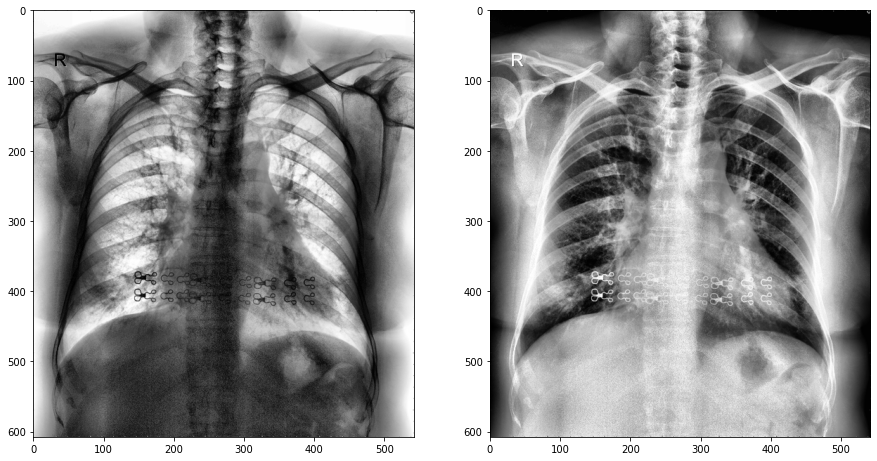

In [10]:
filename = '9a5094b2563a1ef3ff50dc5c7ff71345'
orig, inv = bound(csv, 10, filename)
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)
ax[0].imshow(orig)
ax[1].imshow(inv)
csv[csv['image_id'] == filename]

## Enhancing images using skimage

In [11]:
from skimage import exposure
plt.figure(figsize=(15,8))
type(exposure.equalize_adapthist(read_image(filename)))

numpy.ndarray

<Figure size 1080x576 with 0 Axes>

# Dealing with missing images

Analyzing `train.csv` file it seems that there are approximately about 3500 values images that are misspelled. This is about 20% of the data. We need to correct this by first finding all the image names that are found in the train folder but not in the csv file, and then replacing the names in the CSV file with the names of the images in the folder. The only discrepancy between the names seems to be with missing characters - either at the beginning or at the end - in the file names. For instance `676159c609acb0438313f254a07033b` in the train folder is named is named `676159c609acb0438313f254a07033bd` in the CSV file.

In [8]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f[:-4] for f in listdir('../train/') if isfile(join('../train/', f))]
images = np.unique(csv['image_id'].values)
for f in onlyfiles:
    if f not in images:
        indices = np.argwhere(csv['image_id'].str.contains(f).values == True).ravel()
        csv.loc[indices, 'image_id'] = f

KeyboardInterrupt: 

# Data Augmentations

## Horizontal Flip

Before generating our anchor boxes we need to augment our data. The first augmentation we are going to perform is horizontally flipping our images, and also generating a flipped version of the bounding boxes. Let's first write our flip function which takes in the (x,y)-coordinates of the bounding box and the pixel array of the image and returns the new flipped bounding box and the new flipped pixel array.

In [6]:
def hflip_bbox(x_min, y_min, x_max, y_max, pixels):
    h, w, _ = pixels.shape
    if not (math.isnan(x_min) or math.isnan(y_min) or math.isnan(x_max) or math.isnan(y_max)):
        x_min = w - x_min
        x_max = w - x_max
        x_min, x_max = x_max, x_min
    return x_min, y_min, x_max, y_max

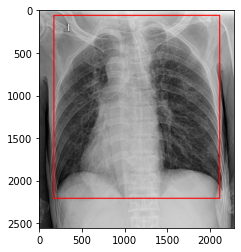

In [7]:
pixels = read_image(filename)
pixels = np.flip(pixels, axis=1)
x_min, y_min, x_max, y_max = map(int, list(csv[csv['image_id'] == filename].values[3][4:]))
x_min, y_min, x_max, y_max = hflip_bbox(x_min, y_min, x_max, y_max, pixels)
plt.imshow(make_box(x_min, y_min, x_max, y_max, pixels))

In [8]:
images = np.unique(csv['image_id'].values)
for p,i in enumerate(images):
    print(f'progress: {np.round((p+1)/len(images)*100.0, 2)}       \r', end='')
    pixels = read_image(i)
    pixels = np.flip(pixels, axis=1)
    rows = csv[csv['image_id']==i].values
    for b in rows:
        class_name, class_id, rad_id = b[1:4]
        x_min, y_min, x_max, y_max = b[4:]
        x_min, y_min, x_max, y_max = hflip_bbox(x_min, y_min, x_max, y_max, pixels)
        csv.loc[len(csv)] = [f'{i}_flipped', class_name, class_id, rad_id, x_min, y_min, x_max, y_max]
    
    # write
    pixels = np.uint8(pixels[:, :, 0])
    with open(f'../train_flipped/{i}_flipped.png', 'wb') as png_file:
        shape = pixels.shape
        png.Writer(shape[1], shape[0], bitdepth=8).write(png_file, pixels.tolist())

In [10]:
csv.to_csv('../augmented_train.csv', index=False)

# Add height and width parameters

In [4]:
csv = pd.read_csv('../augmented_train.csv')
csv

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
135823,fff0f82159f9083f3dd1f8967fc54f6a_flipped,No finding,14,R9,NaN,NaN,NaN,NaN
135824,fff0f82159f9083f3dd1f8967fc54f6a_flipped,No finding,14,R14,NaN,NaN,NaN,NaN
135825,fff2025e3c1d6970a8a6ee0404ac6940_flipped,No finding,14,R1,NaN,NaN,NaN,NaN
135826,fff2025e3c1d6970a8a6ee0404ac6940_flipped,No finding,14,R5,NaN,NaN,NaN,NaN


In [ ]:
images = csv['image_id'].values
csv.insert(1, 'height', [read_image(f'../train/{i}').shape[0] for i in images], True)
csv

# Normalize the bounding boxes

# Create the anchor boxes

In [5]:
csv = pd.read_csv('../augmented_train.csv')
csv

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
135823,fff0f82159f9083f3dd1f8967fc54f6a_flipped,No finding,14,R9,NaN,NaN,NaN,NaN
135824,fff0f82159f9083f3dd1f8967fc54f6a_flipped,No finding,14,R14,NaN,NaN,NaN,NaN
135825,fff2025e3c1d6970a8a6ee0404ac6940_flipped,No finding,14,R1,NaN,NaN,NaN,NaN
135826,fff2025e3c1d6970a8a6ee0404ac6940_flipped,No finding,14,R5,NaN,NaN,NaN,NaN


In [19]:
csv[csv['image_id']=='000434271f63a053c4128a0ba6352c7f']['class_id'].values==14

array([ True,  True,  True])

In [15]:
np.unique(csv[csv['class_name']=='No finding']['image_id'].values, return_counts=True)

(array(['000434271f63a053c4128a0ba6352c7f',
        '000434271f63a053c4128a0ba6352c7f_flipped',
        '00053190460d56c53cc3e57321387478', ...,
        'fff0f82159f9083f3dd1f8967fc54f6a_flipped',
        'fff2025e3c1d6970a8a6ee0404ac6940',
        'fff2025e3c1d6970a8a6ee0404ac6940_flipped'], dtype=object),
 array([3, 3, 3, ..., 3, 3, 3]))